In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('act_train.csv', parse_dates = ['date'])
test = pd.read_csv('act_test.csv', parse_dates = ['date'])
people = pd.read_csv('people.csv', parse_dates = ['date'])

In [3]:
train.head(2)

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [4]:
test.head(2)

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN
1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 682


In [5]:
people.head(2)

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,...,False,True,True,True,True,True,True,True,False,76


In [6]:
# Save the test IDs for Kaggle submission
test_ids = test['activity_id']

def preprocess_acts(data, train_set=True):
    
    # Getting rid of data feature for now
    data = data.drop(['date', 'activity_id'], axis=1)
    if(train_set):
        data = data.drop(['outcome'], axis=1)
    
    ## Split off _ from people_id
    data['people_id'] = data['people_id'].apply(lambda x: x.split('_')[1])
    data['people_id'] = pd.to_numeric(data['people_id']).astype(int)
    
    columns = list(data.columns)
    
    # Convert strings to ints
    for col in columns[1:]:
        data[col] = data[col].fillna('type -999')
        data[col] = data[col].apply(lambda x: x.split(' ')[1])
        data[col] = pd.to_numeric(data[col]).astype(int)
    return data

def preprocess_people(data):
    
    # TODO refactor this duplication
    data = data.drop(['date'], axis=1)
    data['people_id'] = data['people_id'].apply(lambda x: x.split('_')[1])
    data['people_id'] = pd.to_numeric(data['people_id']).astype(int)
    
    #  Values in the people df is Booleans and Strings    
    columns = list(data.columns)
    bools = columns[11:]
    strings = columns[1:11]
    
    for col in bools:
        data[col] = pd.to_numeric(data[col]).astype(int)        
    for col in strings:
        data[col] = data[col].fillna('type -999')
        data[col] = data[col].apply(lambda x: x.split(' ')[1])
        data[col] = pd.to_numeric(data[col]).astype(int)
    return data

In [7]:
# Preprocess each df
peeps = preprocess_people(people)
actions_train = preprocess_acts(train)
actions_test = preprocess_acts(test, train_set=False)

In [8]:
# Merege into a unified table

# Training 
features = actions_train.merge(peeps, how='left', on='people_id')
labels = train['outcome']

# Testing
df_test = actions_test.merge(peeps, how='left', on='people_id')

# Check it out...
features.sample(5)

,people_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,char_8_x,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
867017,247268,2,-999,-999,-999,-999,-999,-999,-999,-999,...,0,0,0,0,0,0,0,0,0,76
1459583,342471,2,-999,-999,-999,-999,-999,-999,-999,-999,...,0,0,0,0,0,0,0,0,0,69
1832793,39806,5,-999,-999,-999,-999,-999,-999,-999,-999,...,0,0,1,0,1,0,0,0,0,90
94187,108295,5,-999,-999,-999,-999,-999,-999,-999,-999,...,0,0,0,0,0,0,0,0,0,84
1456021,341775,4,-999,-999,-999,-999,-999,-999,-999,-999,...,0,0,0,0,0,1,0,0,0,85


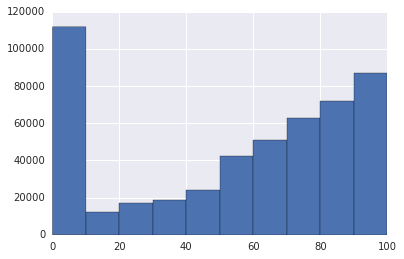

In [9]:
df_test.char_38.hist()

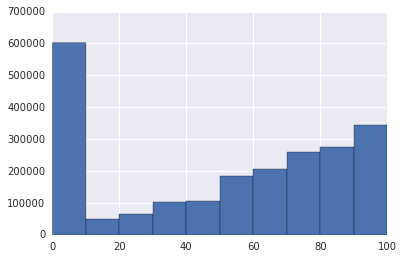

In [10]:
features.char_38.hist()

In [11]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scale = StandardScaler()

In [14]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [15]:
# label kfold on people_id works bad :(
# and statified kfold too

In [17]:
features = features[['char_38','group_1']]

In [18]:
f = features.copy()

In [19]:
f['quadr_38'] = f['char_38']**2
#f['quadr_gr_1'] = f['group_1']**2
f['ln_38'] = f['char_38'].apply(lambda x: np.log(x+0.01))
f['ln_gr_1'] = f['group_1'].apply(lambda x: np.log(x+0.01))

In [65]:
#f[f['ln_38']==-np.inf] = -100000

In [24]:
#kf = StratifiedKFold(train_data['char_38'], n_folds=3)
kf = StratifiedKFold(f['char_38'], n_folds=3)
#for i in [10**-i for i in range(-10,10)]:
for i in range(2,10,1):
    score = []
    n = 1
    for train_index, cv_index in kf:
        print '№ ', n,' fold for value :', i
        #train_data, check_data = features.ix[train_index], features.ix[cv_index]
        train_data, check_data = f.ix[train_index], f.ix[cv_index]
        train_labels, check_labels = labels[train_index], labels[cv_index]
        
        #lr = LogisticRegression(C=i)
        gb = GradientBoostingClassifier(n_estimators=79, max_depth=4, verbose=1, min_samples_split=i)
        #lr.fit(train_feat, train_labels)
        gb.fit(train_data, train_labels)
        #pred = lr.predict(check_feat)
        pred = gb.predict(check_data)
        score.append(roc_auc_score(check_labels, pred))
        
        n += 1
    print(i, np.mean(score))

№  1  fold for value : 2
      Iter       Train Loss   Remaining Time 
         1           1.2695            1.16m
         2           1.1839            1.17m
         3           1.1126            1.18m
         4           1.0527            1.16m
         5           1.0016            1.15m
         6           0.9581            1.13m
         7           0.9210            1.12m
         8           0.8886            1.10m
         9           0.8609            1.09m
        10           0.8366            1.07m
        20           0.7107           54.56s
        30           0.6667           44.98s
        40           0.6485           35.91s
        50           0.6390           26.69s
        60           0.6312           17.48s
        70           0.6250            8.26s
№  2  fold for value : 2
      Iter       Train Loss   Remaining Time 
         1           1.2702            1.29m
         2           1.1848            1.26m
         3           1.1138            1.23m
   

KeyboardInterrupt: 

In [21]:
#for i in range(1,10,1):
#    gb = GradientBoostingClassifier(n_estimators=10, max_depth=i, verbose=1)
#    score = cross_val_score(gb, features, labels, cv=3, scoring='roc_auc').mean()
#    print(i, score)

In [25]:
#gb = GradientBoostingClassifier(n_estimators=200, max_depth=9, verbose=1)
gb = GradientBoostingClassifier(n_estimators=79, max_depth=4, verbose=1)
gb.fit(f, labels)

      Iter       Train Loss   Remaining Time 
         1           1.2696            2.09m
         2           1.1843            2.10m
         3           1.1133            2.07m
         4           1.0537            2.04m
         5           1.0031            2.00m
         6           0.9601            1.98m
         7           0.9232            1.95m
         8           0.8913            1.92m
         9           0.8637            1.89m
        10           0.8400            1.86m
        20           0.7131            1.58m
        30           0.6713            1.31m
        40           0.6515            1.05m
        50           0.6406           46.71s
        60           0.6358           30.34s
        70           0.6303           14.34s


GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=4, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=79,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=False)

In [26]:
importances = pd.DataFrame([f.columns,gb.feature_importances_])
importances = importances.transpose()
columns=['name','importance']
importances.columns = columns

In [27]:
importances.sort_values(by=['importance'], ascending=False)

,name,importance
4,ln_gr_1,0.279625
1,group_1,0.273074
0,char_38,0.189292
3,ln_38,0.138525
2,quadr_38,0.119484


In [29]:
t = df_test[['char_38','group_1']].copy()
t['quadr_38'] = t['char_38']**2
#f['quadr_gr_1'] = f['group_1']**2
t['ln_38'] = t['char_38'].apply(lambda x: np.log(x+0.01))
t['ln_gr_1'] = t['group_1'].apply(lambda x: np.log(x+0.01))

In [30]:
#t[t['ln_38']==-np.inf] = -100000

In [31]:
# Test Set Predictions
#test_proba = gb.predict_proba(df_test[['char_38','group_1']])
test_proba = gb.predict_proba(t)
test_preds = test_proba[:,1]

# Format for submission
output = pd.DataFrame({ 'activity_id' : test_ids, 'outcome': test_preds })
output.head()
output.to_csv('redhat.csv', index = False)